In [63]:
import os

from dotenv import load_dotenv
load_dotenv()


True

In [3]:
import cassio

ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")
cassio.init(token = ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
# from langchain_community.vectorstores import chroma


urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/", "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/", "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"]


docs = [WebBaseLoader(url).load() for url in urls]
# print(docs[0])

docs_list = [item for sublist in docs for item in sublist]


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 500, chunk_overlap = 0)
doc_split = text_splitter.split_documents(docs_list)



In [14]:
print(doc_split[1])

page_content='The agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manag

In [15]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

c:\Users\GAURAV\Desktop\Projects\Langchain\langenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\GAURAV\Desktop\Projects\Langchain\langenv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GAURAV\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Pytho

In [21]:
from langchain.vectorstores.cassandra import Cassandra

astra_vectore_store  = Cassandra(embedding = embeddings, table_name="qa_mini_demo", session =None, keyspace=None)

In [22]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vectore_store.add_documents(doc_split)

astra_vectore_index = VectorStoreIndexWrapper( vectorstore =astra_vectore_store)


In [23]:
retriever = astra_vectore_store.as_retriever()

In [24]:
retriever.invoke("what is agent?", ConsistencyLevel = "LOCAL_ONE")

[Document(id='3e20ecae46494c47aa07b33be03a1ece', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [65]:
from langchain_groq import ChatGroq
# key = os.getenv("GROQ_API_KEY")
# print(key)
llm = ChatGroq(groq_api_key = os.getenv("GROQ_API_KEY"), model_name = "Gemma2-9b-It")

In [36]:
from typing import Literal


from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field



class RouterQuery(BaseModel):
    datasource: Literal['vectorstore', "wiki_search"] = Field(..., 
        description="Given a user question choose to route it to wikipedia or a vectorstore",)




structured_llm_router = llm.with_structured_output(RouterQuery)

#prompt

system = """You are an expert at routing a user question to a vectorestore or wikipedia.
The vectorestore contains document releated to agents, prompts engineering, and adversarial attacks.
Use the vectorstore for questionon there topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [("system", system),
     ("human", "{question}"),]
)



question_router = route_prompt | structured_llm_router

print(question_router.invoke({"question" : "what are the types of agent memory"}))

print(question_router.invoke({"question" : "who is rohit sharma"}))


datasource='vectorstore'
datasource='wiki_search'


In [38]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun


Arxiv_tool = ArxivAPIWrapper( top_k_results=1, doc_content_chars_max=300)
arxiv = ArxivAPIWrapper(api_wrapper = Arxiv_tool)



wiki_tool = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki = WikipediaQueryRun(api_wrapper=wiki_tool)

In [39]:
from typing import List

from typing_extensions import TypedDict



class GraphState(TypedDict):
    question : str
    generation:str
    documents:List[str]

    

In [49]:
from langchain.schema import Document


def retrieve(state):
    print("Retriever")
    question = state["question"]
    
    documents = retriever.invoke(question)
    return {"documents" : documents , "question": question}

In [56]:
def wiki_search(state):
    print("Inside Wiki Search")
    question = state["question"]
    print(question)

    docs = wiki.invoke({"query" : question})

    wiki_results = docs

    wiki_results = Document(page_content= wiki_results)


    return {"documents" : wiki_results , "question":question }


In [57]:
def route_question(state):
    print("------ Route Question ------")
    question = state["question"]
    source = question_router.invoke({"question" : question})
    if source.datasource == "wiki_search":
        print("Route Question to wiki search")
        return "wiki_search"
    elif source.datasource == "vectorstore" :
        print("Route Question to RAG")
        return "vectorstore"


In [58]:
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(GraphState)


workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)


workflow.add_conditional_edges(START, route_question, {
    "wiki_search":"wiki_search",
    "vectorstore" : "retrieve",
},)


workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)


app = workflow.compile()

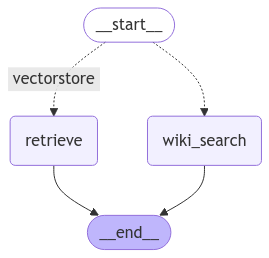

In [59]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [60]:
from pprint import pprint

input= {"question" : "what is agent?"}

for output in app.stream(input):
    for key, value in output.items():

        pprint(f"Node '{key}")

    pprint("\n----\n")

pprint(value['documents'][0].dict()['metadata']['description'])

------ Route Question ------
Route Question to RAG
Retriever
"Node 'retrieve"
'\n----\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results

In [62]:
from pprint import pprint

input= {"question" : "who is Rohit Sharma?"}

for output in app.stream(input):
    for key, value in output.items():

        pprint(f"Node '{key}")

    pprint("\n----\n")

pprint(value['documents'])

------ Route Question ------
Route Question to wiki search
Inside Wiki Search
who is Rohit Sharma?
"Node 'wiki_search"
'\n----\n'
Document(metadata={}, page_content='Page: Rohit Sharma\nSummary: Rohit Gurunath Sharma (born 30 April 1987) is an Indian cricketer and the captain of India national cricket team in Test and ODI formats. Widely regarded as one of the best batsmen of his generation and one of the greatest opening batters of all time, he is also regarded ')
